# Workshop 05

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Text Mining
- Course ID: BDM550NAA.05359.2237
- Professor: Dr. Elnaz Delpisheh

In [176]:
# import all libraries
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Loading & Cleaning Data

In [261]:
# Define function to load and clean text data
def clean_texts(raw_texts: list[str]):
    """
    Return a list of the cleaned sentence(s).

    Processes:
    - tokenize each sentence
    - remove punctuation and stop words
    - handle word stems
    """
    # define result
    result = []

    # set of stopwords
    stop_words = set(stopwords.words('english'))
    # set porter stemmers
    porter = nltk.PorterStemmer()

    # traversing all sentences
    for sent in raw_texts:
        # tokenize
        tokens = word_tokenize(sent)
        # defined cleaned sentence
        clean_sent = ''
        # cleaning each sentence
        for w in tokens:
            # if 'w' is one of punctuations, skip to the next word
            if w in string.punctuation:
                continue
            # if 'w' is one of stop words, skip to the next word
            if w.lower() in stop_words:
                continue
            # add stemmed word to clean_sent
            clean_sent += porter.stem(w.lower()) + ' '

        # add clean_sent to result (make sure that the last item is always blank)
        result += [clean_sent[:-1]]

    return result

In [276]:
# loading the labeled dataset

# define labels and raw texts.
labels = []
texts = []

# get all .txt file name
for filename in os.listdir('labeled_dataset'):
    # open file
    with open(f'labeled_dataset/{filename}', 'r') as f:
        # get each line one by one
        for line in f:
            # list of lines splitted by tab ('\t')
            line_lst = line.strip().replace('\t', ' ').split(' ', 1)

            # if the first item is not '###'
            if line_lst[0] != '###':
                # add labels
                labels += [line_lst[0]]
                # add text after clearning
                texts += clean_texts([line_lst[1]])

<font color='lightgreen'>
Observations:
<br></br>

- Some datasets has tab ('\t') between labels and texts, but others are not.
- In order to correctlly classify the labels and texts, each line was applied the following three processes;
    - applying strip() method.
    - converting all the tabs ('\t') to the blank (' ').
    - splitting a string by the first blank (' '); then the first item should be labels.


</font>

## Implementing Models

In [277]:
# apply TF-IDF
tf_idf = TfidfVectorizer()
# get the feature matrix and target vector
X = tf_idf.fit_transform(texts)
y = np.array(labels)

X, y.shape

(<315x657 sparse matrix of type '<class 'numpy.float64'>'
 	with 4029 stored elements in Compressed Sparse Row format>,
 (315,))

In [278]:
# show counts of each label
pd.Series(y).value_counts()

MISC    142
OWNX    102
CONT     31
AIMX     26
BASE     14
Name: count, dtype: int64

<font color='lightgreen'>
Observations


- As we can see from the demension of feature matrix, there are 315 datasets, and 657 vocabularies are specified from all the loaded texts.
- Also, there are 4029 non-zero values in the matrix.

- In terms of the frequency of labels in the datasets, its distribution is highly imbalanced; in other words, there are large gaps between the most frequent label and the least one.
- To build better machine learning models, an equal number of class labels would be preferable.

</font>

LR: {'accuracy': 0.73, 'precision': 0.85, 'recall': 0.49, 'f1_score': 0.53}

SVC_poly: {'accuracy': 0.71, 'precision': 0.68, 'recall': 0.55, 'f1_score': 0.68}

SVC_rbf: {'accuracy': 0.76, 'precision': 0.79, 'recall': 0.58, 'f1_score': 0.62}

NB: {'accuracy': 0.74, 'precision': 0.89, 'recall': 0.45, 'f1_score': 0.44}



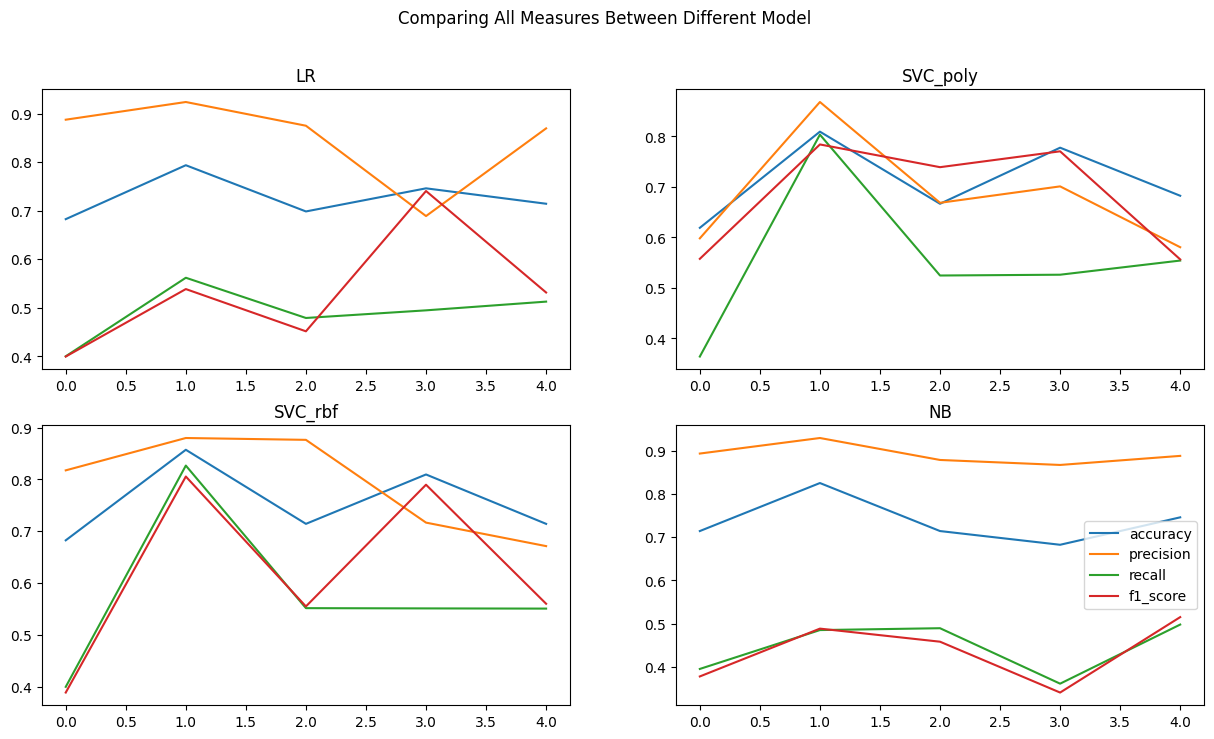

In [279]:
# apply cross validation of 10 holds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# define three models 
models = {"LR": LogisticRegression(multi_class='multinomial'), 
          "SVC_poly": SVC(kernel='poly'), 
          "SVC_rbf": SVC(kernel='rbf'), 
          "NB": MultinomialNB()}
# dictionary of all measures
ms = {}
# define figure
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Comparing All Measures Between Different Model')

for i, (name, model) in enumerate(models.items()):
    # create space for each model
    ms[name] = {m: [] for m in ['accuracy', 'precision', 'recall', 'f1_score']}

    # training model and calculating measures
    for train_idx, test_idx in kf.split(X):
        # define train and test data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # train the model
        model.fit(X_train, y_train)
        # generate the predicted labels
        y_hat = model.predict(X_test)
        # calculate all measures
        ms[name]['accuracy'].append(accuracy_score(y_test, y_hat))
        ms[name]['precision'].append(precision_score(y_test, y_hat, average='macro', zero_division=1))
        ms[name]['recall'].append(recall_score(y_test, y_hat, average='macro', zero_division=1))
        ms[name]['f1_score'].append(f1_score(y_test, y_hat, average='macro', zero_division=1))

    # display average of each measure
    mean_measure = {k: round(np.mean(v), 2) for k, v in ms[name].items()}
    print(f"{name}: {mean_measure}")
    print("") 

    # visualizing measures
    row, col = i // 2, i % 2
    ax[row][col].set_title(name)
    for m in ['accuracy', 'precision', 'recall', 'f1_score']:
        ax[row][col].plot(ms[name][m], label=m)

plt.legend()

<font color='lightgreen'>
Observations:<br>

- In this phase, four different machine learning models are trained under the 5-folds of cross-validations.
- Also, to compare and contract each model, four types of measures are employed; Acuracy, Precision, Recall, and f1-score.
- In terms of those evaluation measures except for accuracy, the Laplace smoothing (adding 1) is conducted in order to avoid the zero devision error.
- Furthermore, macroaveraging strategy is adapted to three measures except for acccuracy; taking into consideration average of each measure for individual categories. 
<br><br>
- The accuracy of the SVC with RBF kernel slightly outperformed other models, but if we focus on the f1-score (the balanced measure between precision and recall), the SVC with a polynomial kernel showed the highest value.
- Compared with the SVC models, Logistics regression and Multi-nomial Naive Bayes showed lower f1-score and had bigger gaps between precisions and recalls; those two underperformed models might be skewed toward specific class labels in the prediction.
<br><br>
- If we had to select the best model from four of them, the SVC with a polynomial kernel might be elected because of the highest f1-score and lower gaps between precisions and recalls, despite underperforming the accuracy.


</font>

## Predicting Unlabaled Texts

In [281]:
# predicting labels for new texts

new_text_files = {}

# get all .txt file name
for filename in os.listdir('unlabeled_dataset'):
    # loading unlabeled file
    with open(f'unlabeled_dataset/{filename}', 'r') as inputs:
        # open new text file
        with open(f'pred_{filename}', 'w') as outputs:
            # get each line one by one
            for i, line in enumerate(inputs):
                # if the first three letters are "###", just add its sentence
                if line[:3] == "###":
                    # define the sentence to be added
                    add_sent = line.strip()

                else:
                    # TF-IDF format of fature matrix
                    X_ = tf_idf.transform(clean_texts([line.strip()]))
                    # define predicted labels from different model
                    y_hats = []
                    for k, v in models.items():
                        # get the predicted label
                        y_hats.append(str(models[k].predict(X_)[0]))

                    # define sentence to be added
                    add_sent = " ".join(y_hats) + "\t" + line.strip()

                # writing results to the output text file
                if i == 0:
                    outputs.write(" ".join(models.keys()) + "\n")
                        
                outputs.write(add_sent + "\n")


<font color='lightgreen'>

Description of the output text files


- Both text files "pred_1.txt" and "pred_2.txt" have almost the same structure as the original unlabeled datasets.
- The first line shows four types of machine learning models; "LR SVC_poly SVC_rbf NB", which indicates Logistics Regression, Support vector classifier by a polynomial and RBF kernel, and the Multi-nomial Naive Bayes in order.
- There are four predicted labels before each sentence; four predicted results are corresponding with each machine learning model.
- For example, focusing on the first two lines of the text file "pred_1.txt" as shown below, 
    - In the first text, only Multi-nomial Naive Bayes predicts "OWNX", but the other three models predict "MISC".
    - In the second text, only SVC with a polynomial kernel predicts "MISC", but the other three models predict "OWNX".

``` 
(pred_1.txt)
LR SVC_poly SVC_rbf NB
### abstract ###
MISC MISC MISC OWNX	Whole-genome transporter ...
OWNX MISC OWNX OWNX	For each organism, ...
```

</font>